In [183]:
# Dependencies
import sqlalchemy
from sqlalchemy import create_engine, MetaData
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Numeric, Text, Float, Date
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns

In [4]:
#Create Engine
engine = create_engine("sqlite:///hawaii.sqlite",echo=False)
conn = engine.connect()

In [6]:
#automap
Base=automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurements', 'stations']

In [11]:
Measurement=Base.classes.measurements
Station=Base.classes.stations

In [12]:
session=Session(engine)

# Precipitation Analysis

In [66]:
lastyear=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>'2017-04-25').all()

In [67]:
dates=[datetime.strptime(data.date,'%Y-%m-%d') for data in lastyear]
prcp=[data.prcp for data in lastyear]
a=pd.DataFrame({'Date':dates,"Precipitation":prcp}).set_index('Date')

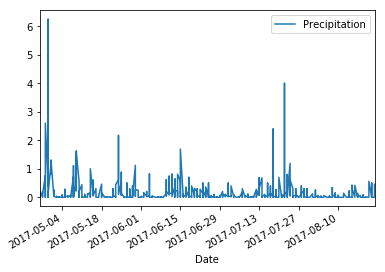

In [68]:
#Plot Results
import matplotlib.pyplot as plt
a.plot()
plt.show()

In [65]:
#Summary Statistics
a.describe()

,Precipitation
count,625.000000
mean,0.150720
std,0.406165
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.250000


# Station Analysis

In [82]:
#Total Number of Stations
conn.execute("select count(Station) from stations").fetchall()

[(9,)]

In [91]:
#Most Active Stations by descending Order
conn.execute("select station,count(station) from measurements group by station order by count(station) desc").fetchall()

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

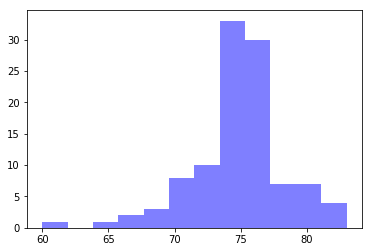

In [151]:
#Last 12 months of temperature observation data from most active station
data=conn.execute("select tobs from measurements where station = 'USC00519281' and date>'2017-04-25'").fetchall()
data=[i[0] for i in data]
num_bins=12
n, bins, patches = plt.hist(data, num_bins, facecolor='blue', alpha=.5)
plt.show()

# Temperature Analysis

In [172]:
def calc_temps(start,end):
    minimum= conn.execute(f"select min(tobs) from measurements where date>={start} and date <={end}").fetchall()[0][0]
    maximum=conn.execute(f"select max(tobs) from measurements where date>={start} and date <={end}").fetchall()[0][0]
    sumation,total=conn.execute(f"select sum(tobs),count(tobs) from measurements where date>={start} and date <={end}").fetchall()[0]
    average=sumation/total
    return minimum, average, maximum

In [176]:
minimum, average, maximum=calc_temps('2017-01-01','2018-01-01')

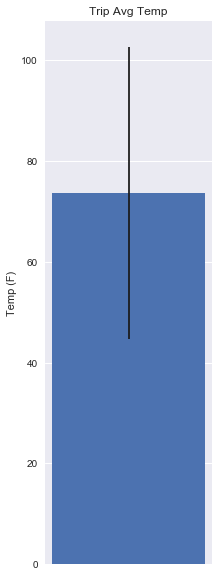

In [198]:
plt.figure(figsize=(3,10))
plt.axes().get_xaxis().set_visible(False)
plt.bar(0,average,.5,align='center',yerr=maximum-minimum)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.show()

# Rainfall per Weather Station

In [200]:
conn.execute("select station,sum(prcp) from measurements where date>'2017-04-25' group by station").fetchall()


[('USC00513117', 13.449999999999992),
 ('USC00514830', 10.27999999999999),
 ('USC00516128', 38.7),
 ('USC00517948', 0.13),
 ('USC00519281', 16.86),
 ('USC00519397', 2.869999999999999),
 ('USC00519523', 11.910000000000005)]

# Daily Normals

In [213]:
def daily_normals(date):
    minimum=conn.execute(f"select min(tobs) from measurements where date like '20%%-{date}' ").fetchall()[0][0]
    maximum=conn.execute(f"select max(tobs) from measurements where date like '20%%-{date}' ").fetchall()[0][0]
    sumation,count=conn.execute(f"select sum(tobs),count(tobs) from measurements where date like '20%%-{date}' ").fetchall()[0]
    average=sumation/count
    return minimum,average,maximum

In [220]:
listofdates=['01-01','01-02','01-03','01-04','01-05','01-06','01-07']
dates=['2018-'+i for i in listofdates]

In [217]:
mins=[]
avgs=[]
maxs=[]
for i in listofdates:
    a,b,c=daily_normals(i)
    mins.append(a)
    avgs.append(b)
    maxs.append(c)

In [244]:
a=pd.DataFrame({"Date":dates,"TMin":mins,"TAvg":avgs,"TMax":maxs})

In [245]:
a.set_index("Date")

,TAvg,TMax,TMin
Date,,,
2018-01-01,69.060000,77,62
2018-01-02,69.408163,77,60
2018-01-03,68.833333,77,62
2018-01-04,69.836364,76,58
2018-01-05,68.000000,76,56
2018-01-06,68.886792,76,61
2018-01-07,68.381818,76,57


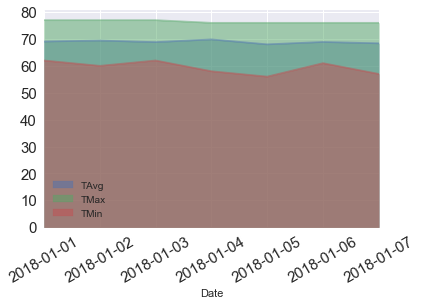

In [248]:
a.plot.area(x=a.Date,alpha=.5,rot=30,fontsize=15,stacked=False)
plt.show()